**Group Members**

1. 6310422053 เมธี ประเสริฐกิจพันธุ์

2. 6310422031 ธนัตถ์กรณ์ ชื่นบรรลือสุข

3. 6310422042 พีรณัฐ เชื้อสวย

# **Load Dependencies**

In [ ]:
!pip install pycaret

  Using cached pycaret-2.3.4-py3-none-any.whl (266 kB)
     |████████████████████████████████| 271 kB 6.7 MB/s 
  Using cached mlxtend-0.19.0-py2.py3-none-any.whl (1.3 MB)
     |████████████████████████████████| 56 kB 4.5 MB/s 
  Using cached pyLDAvis-3.3.1.tar.gz (1.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.8 MB 33.8 MB/s 
     |████████████████████████████████| 111 kB 62.6 MB/s 
     |████████████████████████████████| 80 kB 10.1 MB/s 
     |████████████████████████████████| 14.6 MB 125 kB/s 
  Using cached imbalanced_learn-0.7.0-py3-none-any.whl (167 kB)
  Using cached lightgbm-3.2.1-py3-none-manylinux1_x86_64.whl (2.0 MB)
  Using cached pandas_profiling-3.0.0-py2.py3-none-any.whl (248 kB)
     |████████████████████████████████| 102 kB 58.8 MB/s 
     |████████████████████████████████| 636 kB 42.3 MB/s 
     |██

In [ ]:
import numpy as np
import pandas as pd
from pycaret.clustering import *

# **Load Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/7105/Code Templates/Supermarket Data.csv')

In [ ]:
df['SHOP_DATE'] = df['SHOP_DATE'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [ ]:
df.tail(5)

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,PROD_CODE_40,CUST_CODE,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_ID,BASKET_SIZE,BASKET_PRICE_SENSITIVITY,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION
956569,200617,2006-06-22,5,12,3,3.96,PRD0904997,CL00074,DEP00021,G00007,D00002,NaN,NaN,NaN,994101100088778,M,MM,Top Up,Fresh,STORE00002,LS,W01
956570,200633,2006-10-13,6,20,3,3.96,PRD0904997,CL00074,DEP00021,G00007,D00002,NaN,NaN,NaN,994102700099738,L,LA,Top Up,Fresh,STORE00002,LS,W01
956571,200617,2006-06-22,5,18,3,3.96,PRD0904997,CL00074,DEP00021,G00007,D00002,CUST0000544241,LA,YA,994101100506174,L,LA,Top Up,Fresh,STORE00002,LS,W01
956572,200619,2006-07-06,5,19,3,3.96,PRD0904997,CL00074,DEP00021,G00007,D00002,CUST0000423155,LA,YF,994101300433650,L,LA,Full Shop,Fresh,STORE00002,LS,W01
956573,200635,2006-10-23,2,21,3,3.96,PRD0904997,CL00074,DEP00021,G00007,D00002,NaN,NaN,NaN,994102900104676,L,MM,Top Up,Fresh,STORE00002,LS,W01


In [ ]:
for column in df.columns:
  print(f"{column}: {len(pd.unique(df[column]))}")

In [ ]:
df.info

<bound method DataFrame.info of         SHOP_WEEK  SHOP_DATE  SHOP_WEEKDAY  SHOP_HOUR  QUANTITY  SPEND  \
0          200732 2007-10-05             6         17         3   6.75   
1          200733 2007-10-10             4         20         3   6.75   
2          200741 2007-12-09             1         11         1   2.25   
3          200731 2007-09-29             7         17         1   2.25   
4          200737 2007-11-10             7         14         3   6.75   
...           ...        ...           ...        ...       ...    ...   
956569     200617 2006-06-22             5         12         3   3.96   
956570     200633 2006-10-13             6         20         3   3.96   
956571     200617 2006-06-22             5         18         3   3.96   
956572     200619 2006-07-06             5         19         3   3.96   
956573     200635 2006-10-23             2         21         3   3.96   

         PROD_CODE PROD_CODE_10 PROD_CODE_20 PROD_CODE_30 PROD_CODE_40  \
0    

# **Prepare customer single view**

# Define features

Total visits = COUNT(DISTINCT BASKET ID)

Ticket size = SUM(SPEND)/COUNT(DISTINCT BASKET ID)

Total no. of SKUs


# Calculate features

In [ ]:
df['SHOP_DATE_MONTH'] = df['SHOP_DATE'].apply(lambda x: f"{x.year} {x.month}")
df['SHOP_DATE_MONTH']

0         2007 10
1         2007 10
2         2007 12
3          2007 9
4         2007 11
           ...   
956569     2006 6
956570    2006 10
956571     2006 6
956572     2006 7
956573    2006 10
Name: SHOP_DATE_MONTH, Length: 956574, dtype: object

In [ ]:
df_cm = df[df['CUST_CODE'].notnull()].groupby(by=['CUST_CODE', 'SHOP_DATE_MONTH']).agg(TotalVisits=('BASKET_ID', 'nunique'),TotalSpend=('SPEND', 'sum')).reset_index()

In [ ]:
df_vpm = df_cm.groupby(by=['CUST_CODE']).agg(AvgVisitsPerMonth=('TotalVisits', np.mean),ARPU=('TotalSpend', np.mean)).reset_index()

In [ ]:
df_bdm = df[df['CUST_CODE'].notnull()].groupby(by=['CUST_CODE', 'BASKET_ID']).agg(
    BasketDominantMode=("BASKET_DOMINANT_MISSION", lambda x: x.value_counts().index[0])).reset_index()

In [ ]:
df_bdm = df_bdm.groupby(by=['CUST_CODE']).agg(BasketDominantMode=("BasketDominantMode", lambda x: x.value_counts().index[0])).reset_index()

In [ ]:
##prepare customer single view
df_csv = df_groupby = df[df['CUST_CODE'].notnull()].groupby(by=['CUST_CODE']).agg(TotalSpend=('SPEND', 'sum'),
                                                                                  TotalQuantity=('QUANTITY', 'sum'),
                                                                                  TotalVisits=('BASKET_ID', 'nunique'),
                                                                                  TotalSKUs=('PROD_CODE', 'nunique'),
                                                                                  MedShopHour=('SHOP_HOUR', 'median'),
                                                                                  FirstDate=('SHOP_DATE', 'min'),
                                                                                  LastDate=('SHOP_DATE', 'max'),
                                                                                  ).reset_index()

In [ ]:
df_csv = pd.merge(df_csv, df_vpm, how='left', on='CUST_CODE')
df_csv = pd.merge(df_csv, df_bdm, how='left', on='CUST_CODE')

In [ ]:
df_csv_weekday = df_groupby = df[(df['CUST_CODE'].notnull())&
                                 (df["SHOP_WEEKDAY"].isin([1,7]))].groupby(by=['CUST_CODE']).agg(
                                                      CountShopWeekDay=('SHOP_WEEK','count')
                                                      ).reset_index().sort_values(by=['CUST_CODE',
                                                                          'CountShopWeekDay'], ascending=[True,False])
df_csv_weekday_total = df_groupby = df[(df['CUST_CODE'].notnull())].groupby(by=['CUST_CODE']).agg(
                                                      CountShopWeekDayTotal=('SHOP_WEEK','count')
                                                      ).reset_index().sort_values(by=['CUST_CODE',
                                                                          'CountShopWeekDayTotal'], ascending=[True,False])
df_csv_result =  pd.merge(df_csv_weekday, df_csv_weekday_total, how="left", on=["CUST_CODE"])
df_csv_result["percentage_weekday"] =  df_csv_result["CountShopWeekDay"]/  df_csv_result["CountShopWeekDayTotal"]  

In [ ]:
df_csv = pd.merge(df_csv, df_csv_result, how='left', on='CUST_CODE')

In [ ]:
df_csv

,CUST_CODE,TotalSpend,TotalQuantity,TotalVisits,TotalSKUs,MedShopHour,FirstDate,LastDate,AvgVisitsPerMonth,ARPU,BasketDominantMode,CountShopWeekDay,CountShopWeekDayTotal,percentage_weekday
0,CUST0000000181,2.44,1,1,1,13.0,2007-01-06,2007-01-06,1.000000,2.440000,Fresh,1.0,1.0,1.000000
1,CUST0000000369,959.33,923,220,189,16.0,2006-04-16,2008-07-05,7.857143,34.261786,Fresh,176.0,699.0,0.251788
2,CUST0000000689,328.57,334,16,116,19.0,2007-07-22,2008-06-23,1.777778,36.507778,Mixed,31.0,185.0,0.167568
3,CUST0000000998,5.95,6,3,4,11.5,2006-05-04,2006-07-07,1.500000,2.975000,Grocery,2.0,4.0,0.500000
4,CUST0000001163,39.74,34,4,24,15.0,2006-10-22,2008-06-22,1.000000,9.935000,Fresh,24.0,25.0,0.960000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6095,CUST0000999593,453.58,395,30,206,15.0,2006-05-06,2008-04-02,1.578947,23.872632,Fresh,96.0,297.0,0.323232
6096,CUST0000999645,105.11,91,11,46,18.0,2006-04-30,2008-05-08,1.833333,17.518333,Grocery,38.0,60.0,0.633333
6097,CUST0000999654,5.86,6,1,4,14.0,2006-06-25,2006-06-25,1.000000,5.860000,Fresh,4.0,4.0,1.000000
6098,CUST0000999935,444.17,343,21,127,16.0,2006-11-29,2008-06-05,1.615385,34.166923,Fresh,60.0,236.0,0.254237


In [ ]:
##calculate ticket size
df_csv['TicketSize'] = df_csv['TotalSpend']/df_csv['TotalVisits']

In [ ]:
##find max date in the dataset
max_date = df_csv['LastDate'].max()

In [ ]:
##calculate total days of the relationship
df_csv['total_days'] = (df_csv['LastDate'] - df_csv['FirstDate']).dt.days + 1

In [ ]:
##calculate recency days
df_csv['recency'] = (max_date - df_csv['LastDate']).dt.days

In [ ]:
df_csv['BasketSize'] = df_csv['TotalQuantity']/df_csv['TotalVisits']

In [ ]:
df_csv = pd.get_dummies(df_csv, columns=["BasketDominantMode"])

In [ ]:
df_csv.head()

,CUST_CODE,TotalSpend,TotalQuantity,TotalVisits,TotalSKUs,MedShopHour,FirstDate,LastDate,AvgVisitsPerMonth,ARPU,CountShopWeekDay,CountShopWeekDayTotal,percentage_weekday,TicketSize,total_days,recency,BasketSize,BasketDominantMode_Fresh,BasketDominantMode_Grocery,BasketDominantMode_Mixed,BasketDominantMode_Nonfood,BasketDominantMode_XX
0,CUST0000000181,2.44,1,1,1,13.0,2007-01-06,2007-01-06,1.000000,2.440000,1.0,1.0,1.000000,2.440000,1,547,1.000000,1,0,0,0,0
1,CUST0000000369,959.33,923,220,189,16.0,2006-04-16,2008-07-05,7.857143,34.261786,176.0,699.0,0.251788,4.360591,812,1,4.195455,1,0,0,0,0
2,CUST0000000689,328.57,334,16,116,19.0,2007-07-22,2008-06-23,1.777778,36.507778,31.0,185.0,0.167568,20.535625,338,13,20.875000,0,0,1,0,0
3,CUST0000000998,5.95,6,3,4,11.5,2006-05-04,2006-07-07,1.500000,2.975000,2.0,4.0,0.500000,1.983333,65,730,2.000000,0,1,0,0,0
4,CUST0000001163,39.74,34,4,24,15.0,2006-10-22,2008-06-22,1.000000,9.935000,24.0,25.0,0.960000,9.935000,610,14,8.500000,1,0,0,0,0


# **Cluster customers**

In [ ]:
exp_clu = setup(data=df_csv, ignore_features=['CUST_CODE','FirstDate','LastDate','CountShopWeekDay','CountShopWeekDayTotal'], normalize=True)

,Description,Value
0,session_id,2905
1,Original Data,"(6100, 22)"
2,Missing Values,True
3,Numeric Features,17
4,Categorical Features,0
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(6100, 17)"
9,CPU Jobs,-1


In [ ]:
models()

,Name,Reference
ID,,
kmeans,K-Means Clustering,sklearn.cluster._kmeans.KMeans
ap,Affinity Propagation,sklearn.cluster._affinity_propagation.Affinity...
meanshift,Mean Shift Clustering,sklearn.cluster._mean_shift.MeanShift
sc,Spectral Clustering,sklearn.cluster._spectral.SpectralClustering
hclust,Agglomerative Clustering,sklearn.cluster._agglomerative.AgglomerativeCl...
dbscan,Density-Based Spatial Clustering,sklearn.cluster._dbscan.DBSCAN
optics,OPTICS Clustering,sklearn.cluster._optics.OPTICS
birch,Birch Clustering,sklearn.cluster._birch.Birch
kmodes,K-Modes Clustering,kmodes.kmodes.KModes


In [ ]:
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Needs Ground Truth,Custom
ID,,,,,,,,,
silhouette,Silhouette,Silhouette,<function silhouette_score at 0x7fe1d3b8bcb0>,make_scorer(silhouette_score),pred,{},True,False,False
chs,Calinski-Harabasz,Calinski-Harabasz,<function calinski_harabasz_score at 0x7fe1d3b...,make_scorer(calinski_harabasz_score),pred,{},True,False,False
db,Davies-Bouldin,Davies-Bouldin,<function davies_bouldin_score at 0x7fe1d3b90050>,make_scorer(davies_bouldin_score),pred,{},True,False,False
hs,Homogeneity Score,Homogeneity,<function homogeneity_score at 0x7fe1d3bead40>,make_scorer(homogeneity_score),pred,{},True,True,False
ari,Rand Index,Rand Index,<function adjusted_rand_score at 0x7fe1d3beab00>,make_scorer(adjusted_rand_score),pred,{},True,True,False
cs,Completeness Score,Completeness,<function completeness_score at 0x7fe1d3beadd0>,make_scorer(completeness_score),pred,{},True,True,False


# Compare model performance

In [ ]:
metrics = []
for model in models().index:
    if model in ['meanshift', 'optics']:
        continue
    create_model(model)
    metric_result = pull()
    metric_result['model'] = model
    metrics.append(metric_result)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,-0.052,70.1559,8.1948,0,0,0


In [ ]:
cluster_metrics = pd.concat(metrics)
cluster_metrics.set_index("model", inplace=True)
cluster_metrics.sort_values(by='Silhouette', ascending=False, inplace=True)
cluster_metrics.style.highlight_max(subset=['Silhouette', 'Calinski-Harabasz'], color = 'green', axis = 0).highlight_min(subset=['Davies-Bouldin'], color = 'green', axis = 0)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
model,,,,,,
sc,0.899800,152.003600,0.068700,0,0,0
birch,0.337000,1567.560000,1.209700,0,0,0
kmeans,0.248600,2156.578000,1.276900,0,0,0
hclust,0.207500,1800.405500,1.468600,0,0,0
ap,0.171800,302.175000,1.303300,0,0,0
kmodes,-0.052000,70.155900,8.194800,0,0,0
dbscan,-0.408700,30.982000,1.564000,0,0,0


# Spectral Clustering Clustering

In [ ]:
sc = create_model('sc')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.8998,152.0036,0.0687,0,0,0


In [ ]:
plot_model(sc)

# KMeans Clustering

In [ ]:
kmeans = create_model('kmeans', )

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2486,2156.578,1.2769,0,0,0


In [ ]:
print(kmeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=2905, tol=0.0001, verbose=0)


In [ ]:
plot_model(kmeans)

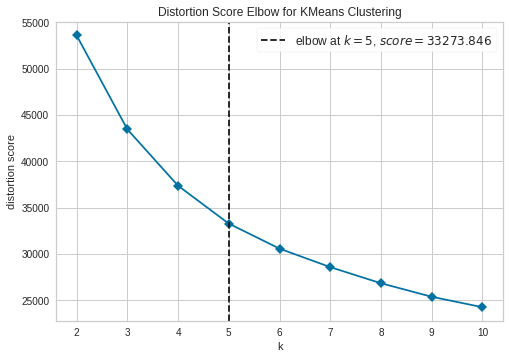

In [ ]:
plot_model(kmeans, plot = 'elbow')

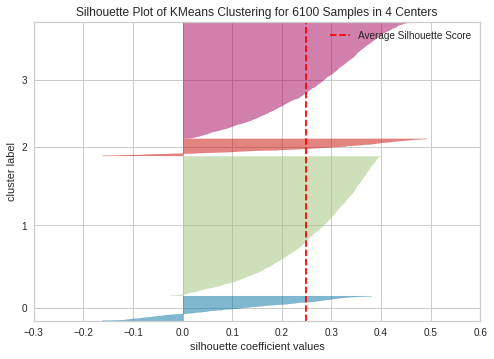

In [ ]:
plot_model(kmeans, plot = 'silhouette')

## https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

# **Interpret results and plan for actions**

In [ ]:
kmean_results = assign_model(kmeans)
kmean_results.head()

,CUST_CODE,TotalSpend,TotalQuantity,TotalVisits,TotalSKUs,MedShopHour,FirstDate,LastDate,AvgVisitsPerMonth,ARPU,CountShopWeekDay,CountShopWeekDayTotal,percentage_weekday,TicketSize,total_days,recency,BasketSize,BasketDominantMode_Fresh,BasketDominantMode_Grocery,BasketDominantMode_Mixed,BasketDominantMode_Nonfood,BasketDominantMode_XX,Cluster
0,CUST0000000181,2.44,1,1,1,13.0,2007-01-06,2007-01-06,1.000000,2.440000,1.0,1.0,1.000000,2.440000,1,547,1.000000,1,0,0,0,0,Cluster 1
1,CUST0000000369,959.33,923,220,189,16.0,2006-04-16,2008-07-05,7.857143,34.261786,176.0,699.0,0.251788,4.360591,812,1,4.195455,1,0,0,0,0,Cluster 2
2,CUST0000000689,328.57,334,16,116,19.0,2007-07-22,2008-06-23,1.777778,36.507778,31.0,185.0,0.167568,20.535625,338,13,20.875000,0,0,1,0,0,Cluster 0
3,CUST0000000998,5.95,6,3,4,11.5,2006-05-04,2006-07-07,1.500000,2.975000,2.0,4.0,0.500000,1.983333,65,730,2.000000,0,1,0,0,0,Cluster 1
4,CUST0000001163,39.74,34,4,24,15.0,2006-10-22,2008-06-22,1.000000,9.935000,24.0,25.0,0.960000,9.935000,610,14,8.500000,1,0,0,0,0,Cluster 3


In [ ]:
from sklearn.model_selection import train_test_split

df_rf = kmean_results.drop(columns=['CUST_CODE','FirstDate','LastDate','CountShopWeekDay','CountShopWeekDayTotal'])
df_rf.dropna(inplace=True)
train_data = df_rf.drop(columns=['Cluster'])
train_res = df_rf['Cluster']

X_train, X_test, y_train, y_test = train_test_split(train_data, train_res, test_size=0.30, random_state=41)

In [ ]:
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="macro", multi_class="ovr"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average, multi_class=multi_class)

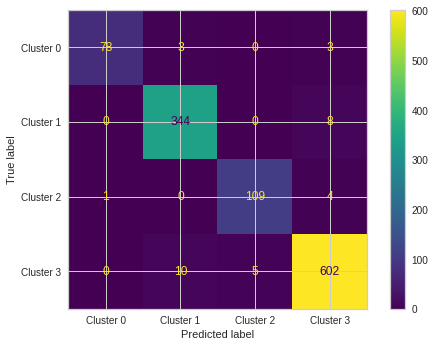

AUC: 0.9735972471178925


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import multilabel_confusion_matrix, plot_confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

clf = RandomForestClassifier(n_jobs=-1, random_state=41)
model = clf.fit(X_train, y_train)

lr_probs = model.predict_proba(X_test)
plot_confusion_matrix(model, X_test, y_test)
plt.show()

y_pred = model.predict(X_test)
print("AUC:", multiclass_roc_auc_score(y_test, y_pred))

In [ ]:
fdf = pd.DataFrame(model.feature_importances_, index=X_test.columns, columns=['imp'])
fdf = fdf.sort_values(by='imp', ascending=False)

print(fdf)

                                 imp
total_days                  0.170470
recency                     0.141739
TotalSpend                  0.107384
TotalVisits                 0.101441
TotalQuantity               0.085366
TicketSize                  0.080240
ARPU                        0.079151
BasketSize                  0.074370
percentage_weekday          0.070135
TotalSKUs                   0.045702
AvgVisitsPerMonth           0.029614
MedShopHour                 0.006864
BasketDominantMode_Mixed    0.003431
BasketDominantMode_Fresh    0.002147
BasketDominantMode_Grocery  0.001157
BasketDominantMode_Nonfood  0.000493
BasketDominantMode_XX       0.000295


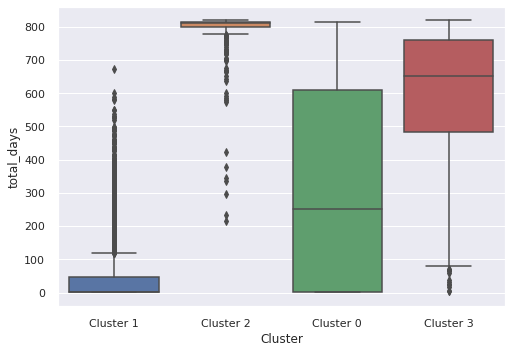

In [ ]:
import seaborn as sns

sns.set(font_scale = 1)
sns.boxplot(x="Cluster", y="total_days", data=kmean_results)

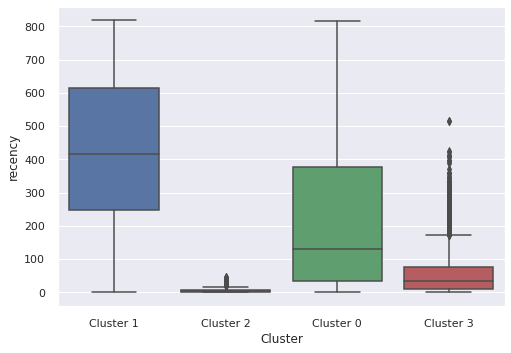

In [ ]:
sns.set(font_scale = 1)
sns.boxplot(x="Cluster", y="recency", data=kmean_results)

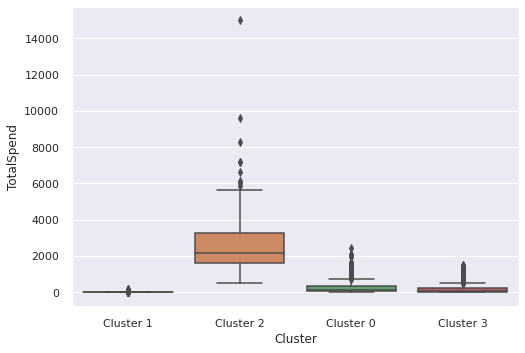

In [ ]:
sns.set(font_scale = 1)
sns.boxplot(x="Cluster", y="TotalSpend", data=kmean_results)

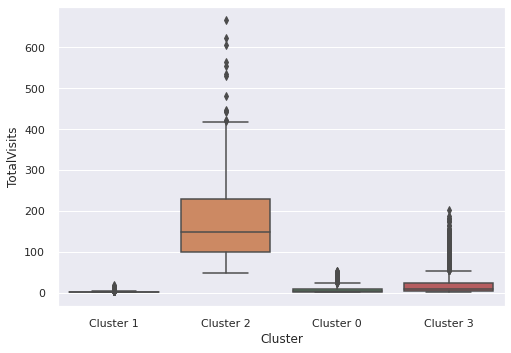

In [ ]:
sns.set(font_scale = 1)
sns.boxplot(x="Cluster", y="TotalVisits", data=kmean_results)

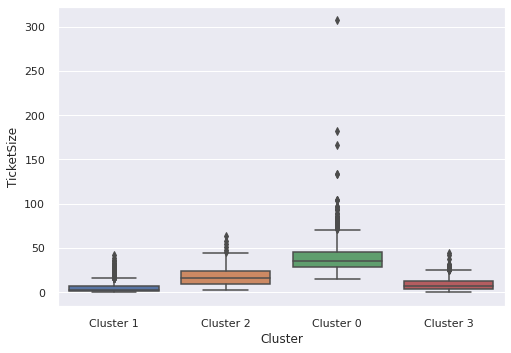

In [ ]:
sns.set(font_scale = 1)
sns.boxplot(x="Cluster", y="TicketSize", data=kmean_results)

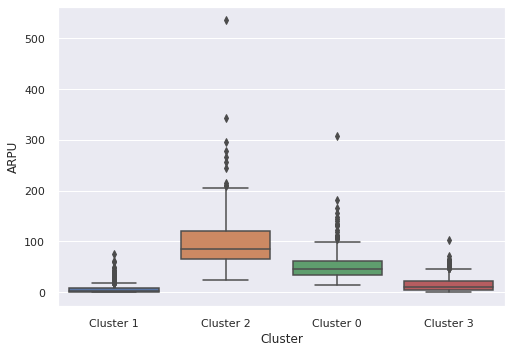

In [ ]:
sns.set(font_scale = 1)
sns.boxplot(x="Cluster", y="ARPU", data=kmean_results)

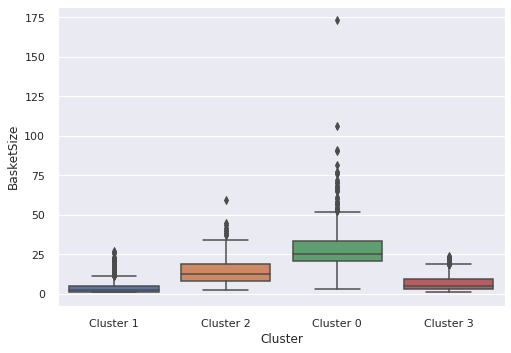

In [ ]:
sns.set(font_scale = 1)
sns.boxplot(x="Cluster", y="BasketSize", data=kmean_results)

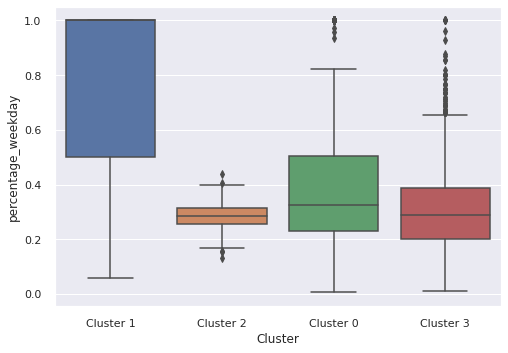

In [ ]:
sns.set(font_scale = 1)
sns.boxplot(x="Cluster", y="percentage_weekday", data=kmean_results)

Cluster 0 - MIA (Missing in action)
- low weekday = high weekend
- large basket size
- medium spend per month
- high ticket size
- low total visits
- medium total spent
- not recent
- other customer

Action:
- ทำบัตรสมาชิก สะสมแต้ม ให้ลูกค้า เพื่อให้ลูก อยากมาบ่อยๆ เพื่อให้ได้ส่วนลด หรือ สิทธิพิเศษใดๆ
- ส่งโบรชัวร์ส่วนลดไปให้ เพื่อให้กลับมาซื้อ


---



Cluster 1 - Conscript
- high weekday = low weekend
- small basket size
- low spend per month
- low ticket size
- low total visits
- low total spent
- not recent
- short time customer

Action:
- ทำบัตรสมาชิก สะสมแต้ม ให้ลูกค้า เพื่อให้ลูก อยากมาบ่อยๆ เพื่อให้ได้ส่วนลด หรือ สิทธิพิเศษใดๆ
- ทำโปรโมชั่นพิเศษวันธรรมดา เพื่อทำให้คนที่มาวันธรรมดามาซื้อเยอะ และบ่อยขึ้น

---




Cluster 2 - Commander
- low weekday = high weekend
- medium basket size
- high spend per month
- medium ticket size
- high total visits
- high total spent
- very recent
- long time customer

Action:
- ให้ Reward พิเศษ อาจจะเป็นของขวัญตามเทศกาล
- ขายสินค้าที่ช่วยเพิ่มความสะดวกสบาย หรูหรา

---



Cluster 3 - Veteran
- low weekday = high weekend
- small basket size
- low spend per month
- low ticket size
- medium total visits
- low total spent
- fairly recent
- long time customer

Action:
- ทำส่วนลดเมื่อซื้อของมากกว่าค่าเฉลี่ยเดิม ที่เขาซื้อ เพื่อ up-sale
- recommend co purchase product